In [30]:
import re
import json

def compile(source, defines=""):
    if defines != "":
        !bash -lc "cd .. && rm build/{source}.bench"
    !bash -lc "cd .. && make -s build/{source}.bench EXTRA_CXXFLAGS='{defines}'"
    
def bench(source, n, defines="", t=2**25, l=64):
    compile(source, defines)
    res = !./../build/{source}.bench {n} {t} {l}
    # print(res)
    return float(str(res).split()[1])

def perf(source, n, t=2**25, l=64):

    PERF_EVENTS = {
        "cycles",
        "instructions",
        "L1-dcache-loads",
        "L1-dcache-load-misses",
        "LLC-loads",
        "LLC-load-misses",
        "cache-references",
        "cache-misses",
    }
    
    compile(source)
    lines = !bash -lc "taskset -c 8 perf stat -r 10 -e cycles,instructions,L1-dcache-loads,L1-dcache-load-misses,LLC-loads,LLC-load-misses,cache-references,cache-misses ./../build/{source}.bench {n} {t} {l}"
    
    data = {}
    for line in lines:
        line = line.split("#", 1)[0]
        m = re.match(r"\s*([\d,]+)\s+([\w\-]+)", line)
        if not m:
            continue

        value = int(m.group(1).replace(",", ""))
        event = m.group(2)

        if event in PERF_EVENTS:
            data[event] = value
    
    return data

In [15]:
perf("matmul12_avx512", 1024, t=2**30)

{'cycles': 1662504611,
 'instructions': 3300689190,
 'L1-dcache-loads': 1928282097,
 'L1-dcache-load-misses': 473027559,
 'cache-references': 1259959185,
 'cache-misses': 4009368}

In [2]:
bench("matmul12_avx512", 1024, t=2**30)

205634210.0

In [4]:
ns = [i for i in range(8, 1024+1, 8)]

In [5]:
names = {
    'matmul1_ikj': 'naive',
    'matmul6_restrict': 'restrict',
    'matmul7_transpose': 'transpose',
    'matmul8_L1_tiles': 'L1_tiles',
    'matmul9_L2_tiles': 'L2_tiles',
    'matmul10_sse': 'sse',
    'matmul11_avx': 'avx',
    'matmul12_avx512': 'avx512',
    'matmul14_kernel': 'kernel', 
}

# results = {name: [bench(source, n) for n in ns] for source, name in names.items()}

# print(results)

In [3]:
import matplotlib.pyplot as plt

    
def plot(results, ns, subset):

    def gflops(l):
        return [n**3 / t / 10**9 for t, n in zip(l, ns)]
    
    plt.figure(figsize=(10,6))
    for label in subset:
        plt.plot(ns, gflops(results[label]), marker='o', linewidth=1, markersize=3, label=label)

    plt.xlabel('n')
    plt.ylabel('GFLOPS')
    plt.ylim(bottom=0)
    plt.margins(0)

    plt.legend()
    
    plt.show()

    
# plot(results, ns, [
# 'naive', 'restrict', 'transpose', 'L1_tiles', 'L2_tiles', 'sse', 'avx', 'avx512', 'kernel'
# ])

In [13]:
def find_opt_kernel():
    results = {}
    names = []

    ns = [5, 25, 125]
    for n in range(255, 513, 25):
        ns.append(n)
    ns.append(1024)
    ns.append(1500)
    ns.append(2000)
    ns.append(2500)

    cand = [(4, 4), (4, 5), (5, 4), (6, 3), (7, 3), (8, 2), (9, 2)]

    for rows, cols in cand:
        print("rows:", rows, "cols:", cols)
        name = f"{rows} {cols}"
        result = [bench("matmul18_kernel", n, defines=f"-DKERNEL_R={rows} -DKERNEL_C={cols}") for n in ns]
        print(result)
        results[name] = result
        names.append(name)

    return (results, ns, names)
    # print(results, name)
    # plot(results, ns, names)
results, ns, names = find_opt_kernel()

rows: 4 cols: 4
[6976.0, 23150.0, 119830.0, 832709.0, 1278907.0, 1500820.0, 2067010.0, 2481281.0, 2721205.0, 3862073.0, 4266110.0, 5167674.0, 5782077.0, 6443211.0, 55275780.0, 177844459.0, 454017713.0, 823077691.0]
rows: 4 cols: 5
[6716.0, 10397.0, 145038.0, 1065545.0, 1232005.0, 1472076.0, 2179129.0, 2457435.0, 2812990.0, 3987593.0, 4506226.0, 4977103.0, 5355238.0, 7356762.0, 51934310.0, 176712888.0, 403356351.0, 795535742.0]
rows: 5 cols: 4
[6071.0, 8574.0, 121589.0, 828103.0, 1230913.0, 1473205.0, 2126802.0, 2403758.0, 2744006.0, 3552437.0, 4197049.0, 5171258.0, 6038807.0, 6348072.0, 56638675.0, 178274325.0, 425628908.0, 813203649.0]
rows: 6 cols: 3
[6118.0, 9269.0, 135703.0, 932648.0, 1122805.0, 1555302.0, 1867483.0, 2372771.0, 2779344.0, 3567352.0, 3940583.0, 4719660.0, 5308819.0, 6534712.0, 56222980.0, 182483926.0, 405653496.0, 1073723498.0]
rows: 7 cols: 3
[6390.0, 8875.0, 124135.0, 944357.0, 1126689.0, 1628097.0, 1841132.0, 2376375.0, 2698658.0, 3604888.0, 3980941.0, 4858529.0,

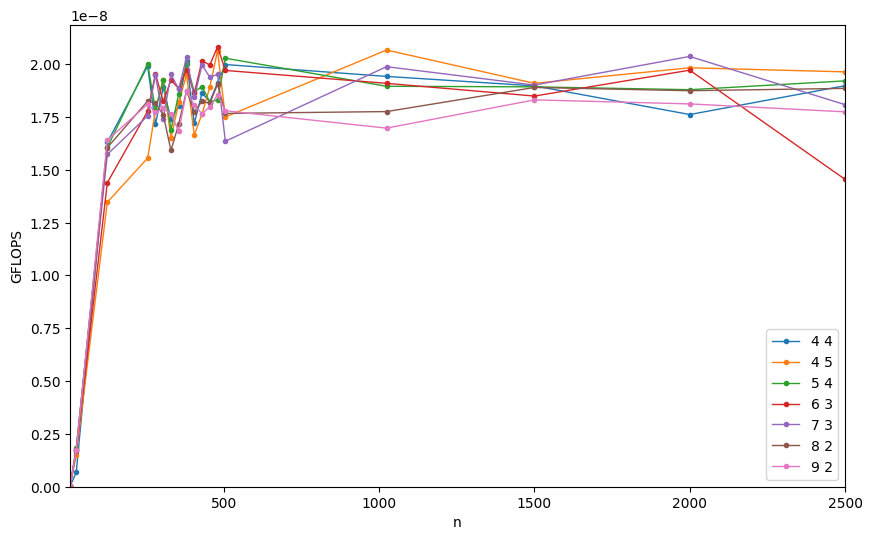

In [14]:
plot(results, ns, names)

In [5]:
def plot_flops(sources, ns):
    results = {}
    for source in sources:
        results[source] = [bench(source, n) for n in ns]
    plot(results, ns, sources)

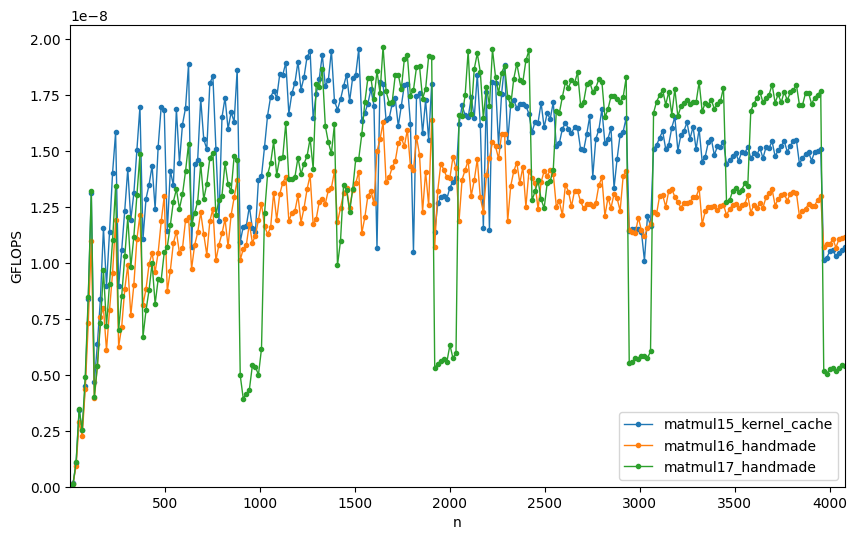

In [7]:
plot_flops(["matmul15_kernel_cache", "matmul16_handmade", "matmul17_handmade"], [n for n in range(1, 2**12+1, 16)])
# plot_flops(["matmul15_kernel_cache"], [n for n in range(1, 2**12+1, 16)])

In [31]:
perf("matmul20_unroll2", 512, t=2**36, l=10000)

{'cycles': 24017144520,
 'instructions': 45480493393,
 'L1-dcache-loads': 18961772118,
 'L1-dcache-load-misses': 6372406597,
 'cache-references': 11976920535,
 'cache-misses': 378241699}

In [32]:
perf("matmul21_prefetch", 512, t=2**36, l=10000)

{'cycles': 90885480790,
 'instructions': 193897600952,
 'L1-dcache-loads': 69987798625,
 'L1-dcache-load-misses': 23604497463,
 'cache-references': 46218285409,
 'cache-misses': 1681743733}